In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 27s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
training_data_df['토지면적over총연면적times공시지가'] = training_data_df['토지면적'] / training_data_df['총연면적'] * training_data_df['공시지가(만원)']

In [14]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_37.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(37, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413


In [15]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413
ynorm,32.778974,33.334156,34.381181,31.948810,31.985028,32.885630
xy,23.169878,22.911403,23.088237,23.200194,22.130894,22.900121
x_2nd,20.970331,19.983670,19.086148,19.561174,18.775874,19.675439
층mean,14.252191,13.117314,10.635972,12.298080,14.361368,12.932985
주건축물수,11.275807,11.011066,11.722058,10.505324,12.096255,11.322102


In [16]:
training_data_df['토지면적over총연면적times공시지가times(전용면적over호수대비연면적)'] = training_data_df['토지면적over총연면적times공시지가'] * (training_data_df['전용면적'] / training_data_df['호수대비연면적'])

In [17]:
training_data_df['토지면적over총연면적times공시지가times(전용면적over호수대비연면적)'].describe()

count    3.658226e+06
mean     2.583643e+02
std      1.972532e+02
min      5.061432e+00
25%      1.454997e+02
50%      2.000233e+02
75%      2.982888e+02
max      2.091205e+04
Name: 토지면적over총연면적times공시지가times(전용면적over호수대비연면적), dtype: float64

In [18]:
new_feature = ['토지면적over총연면적times공시지가times(전용면적over호수대비연면적)']

In [19]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [20]:
training_data_df = training_data_df[shap_summary_df.index.tolist()+new_feature+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 43)


,trade_type,토지면적over총연면적times공시지가,year_linear,건축년도,전용면적,ynorm,xy,x_2nd,층mean,주건축물수,총건축면적,호수대비연면적,토지이동상황,xnorm,아파트지구,옥내자주식대수,호수대비부속건축물면적,총호수,층,y_2nd,호수대비주차수,용도지역명1,층norm,지구단위계획구역,부속건축물수,지형높이,도로접면,가축사육제한구역,옥외자주식대수,층min,지붕_평지붕_fraction,부속건축물면적,건물나이,(한강)폐기물매립시설_설치제한지역,month_sin,지형형상,공원,토지면적over총연면적times공시지가times(전용면적over호수대비연면적),금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,758.319895,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,0.222222,0,0.0,0,0,0,0.0,9.0,1.0,0.0,0,0,-0.866025,0,0,598.341696,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,758.319895,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,0.222222,0,0.0,0,0,0,0.0,9.0,1.0,0.0,0,0,-0.500000,0,0,598.341696,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,758.319895,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,4,4.094180e+07,0.0,0,0.444444,0,0.0,0,0,0,0.0,9.0,1.0,0.0,0,0,0.000000,0,0,598.341696,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,758.319895,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,9,4.094180e+07,0.0,0,1.000000,0,0.0,0,0,0,0.0,9.0,1.0,0.0,0,0,0.866025,0,0,598.341696,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,758.319895,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,1,4.094180e+07,0.0,0,0.111111,0,0.0,0,0,0,0.0,9.0,1.0,0.0,0,0,-0.866025,0,0,598.341696,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [21]:
from sklearn.model_selection import KFold, GroupKFold

In [22]:
import lightgbm as lgb

In [23]:
from sklearn.metrics import r2_score

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

12

In [26]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 38)
y dist plot


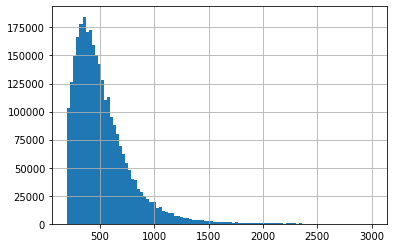

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 38


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4362
[100]	valid_0's huber: 64.6304
[150]	valid_0's huber: 58.6878
[200]	valid_0's huber: 55.0359
[250]	valid_0's huber: 52.6638
[300]	valid_0's huber: 50.9494
[350]	valid_0's huber: 49.6386
[400]	valid_0's huber: 48.4796
[450]	valid_0's huber: 47.565
[500]	valid_0's huber: 46.7975
[550]	valid_0's huber: 46.1887
[600]	valid_0's huber: 45.6157
[650]	valid_0's huber: 44.9944
[700]	valid_0's huber: 44.3944
[750]	valid_0's huber: 43.8552
[800]	valid_0's huber: 43.4462
[850]	valid_0's huber: 43.0479
[900]	valid_0's huber: 42.689
[950]	valid_0's huber: 42.314
[1000]	valid_0's huber: 42.0356
[1050]	valid_0's huber: 41.7361
[1100]	valid_0's huber: 41.4437
[1150]	valid_0's huber: 41.2201
[1200]	valid_0's huber: 40.983
[1250]	valid_0's huber: 40.7676
[1300]	valid_0's huber: 40.5638
[1350]	valid_0's huber: 40.369
[1400]	valid_0's huber: 40.1761
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


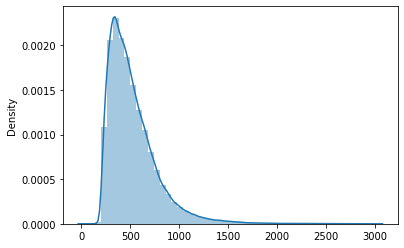

Fold 0 end
Fold 1 start
(2926581, 38)
y dist plot


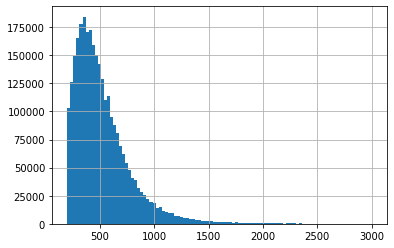

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5151
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 38


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4901
[100]	valid_0's huber: 64.647
[150]	valid_0's huber: 58.5229
[200]	valid_0's huber: 55.0026
[250]	valid_0's huber: 52.6097
[300]	valid_0's huber: 50.8501
[350]	valid_0's huber: 49.5739
[400]	valid_0's huber: 48.4958
[450]	valid_0's huber: 47.5559
[500]	valid_0's huber: 46.856
[550]	valid_0's huber: 46.1782
[600]	valid_0's huber: 45.5711
[650]	valid_0's huber: 44.9988
[700]	valid_0's huber: 44.508
[750]	valid_0's huber: 43.9526
[800]	valid_0's huber: 43.4606
[850]	valid_0's huber: 43.0539
[900]	valid_0's huber: 42.6586
[950]	valid_0's huber: 42.3154
[1000]	valid_0's huber: 41.9875
[1050]	valid_0's huber: 41.6906
[1100]	valid_0's huber: 41.4513
[1150]	valid_0's huber: 41.2098
[1200]	valid_0's huber: 40.991
[1250]	valid_0's huber: 40.8065
[1300]	valid_0's huber: 40.5725
[1350]	valid_0's huber: 40.3527
[1400]	valid_0's huber: 40.1172
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


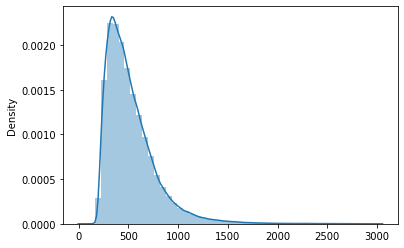

Fold 1 end
Fold 2 start
(2926581, 38)
y dist plot


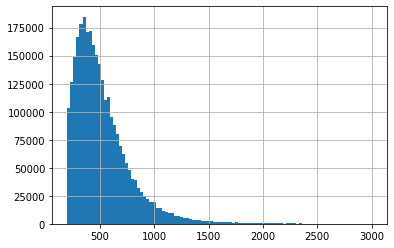

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 38


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.2624
[100]	valid_0's huber: 64.4067
[150]	valid_0's huber: 58.4988
[200]	valid_0's huber: 54.907
[250]	valid_0's huber: 52.5459
[300]	valid_0's huber: 50.7956
[350]	valid_0's huber: 49.5067
[400]	valid_0's huber: 48.261
[450]	valid_0's huber: 47.3975
[500]	valid_0's huber: 46.5956
[550]	valid_0's huber: 45.8134
[600]	valid_0's huber: 45.2796
[650]	valid_0's huber: 44.6905
[700]	valid_0's huber: 44.1949
[750]	valid_0's huber: 43.7573
[800]	valid_0's huber: 43.2672
[850]	valid_0's huber: 42.8347
[900]	valid_0's huber: 42.4758
[950]	valid_0's huber: 42.1522
[1000]	valid_0's huber: 41.8715
[1050]	valid_0's huber: 41.59
[1100]	valid_0's huber: 41.3294
[1150]	valid_0's huber: 41.1058
[1200]	valid_0's huber: 40.8251
[1250]	valid_0's huber: 40.5856
[1300]	valid_0's huber: 40.3881
[1350]	valid_0's huber: 40.1852
[1400]	valid_0's huber: 39.9773
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


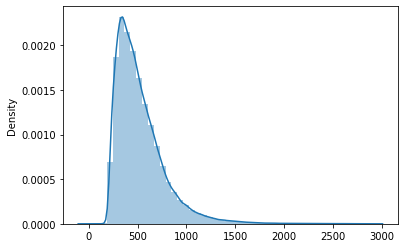

Fold 2 end
Fold 3 start
(2926581, 38)
y dist plot


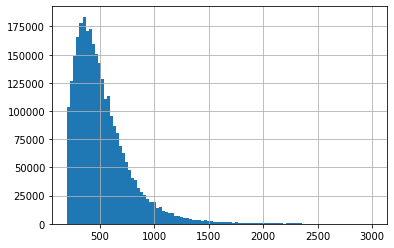

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 38


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4126
[100]	valid_0's huber: 64.7263
[150]	valid_0's huber: 58.4821
[200]	valid_0's huber: 54.9684
[250]	valid_0's huber: 52.5081
[300]	valid_0's huber: 50.7639
[350]	valid_0's huber: 49.4769
[400]	valid_0's huber: 48.4795
[450]	valid_0's huber: 47.6308
[500]	valid_0's huber: 46.7864
[550]	valid_0's huber: 46.1535
[600]	valid_0's huber: 45.6422
[650]	valid_0's huber: 45.0166
[700]	valid_0's huber: 44.4357
[750]	valid_0's huber: 43.9341
[800]	valid_0's huber: 43.5188
[850]	valid_0's huber: 43.1197
[900]	valid_0's huber: 42.7713
[950]	valid_0's huber: 42.3918
[1000]	valid_0's huber: 42.0654
[1050]	valid_0's huber: 41.7841
[1100]	valid_0's huber: 41.5565
[1150]	valid_0's huber: 41.2541
[1200]	valid_0's huber: 40.9937
[1250]	valid_0's huber: 40.7807
[1300]	valid_0's huber: 40.5517
[1350]	valid_0's huber: 40.3349
[1400]	valid_0's huber: 40.1108
[1450]	

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


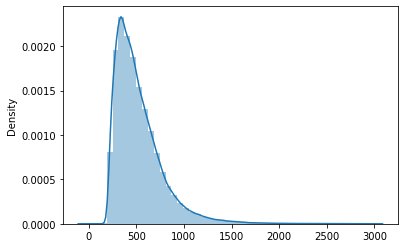

Fold 3 end
Fold 4 start
(2926581, 38)
y dist plot


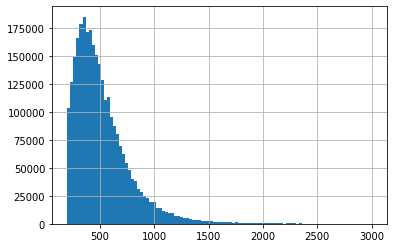

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5148
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 38


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.1008
[100]	valid_0's huber: 64.4614
[150]	valid_0's huber: 58.5424
[200]	valid_0's huber: 55.002
[250]	valid_0's huber: 52.6387
[300]	valid_0's huber: 50.9493
[350]	valid_0's huber: 49.6896
[400]	valid_0's huber: 48.659
[450]	valid_0's huber: 47.7105
[500]	valid_0's huber: 46.9265
[550]	valid_0's huber: 46.2259
[600]	valid_0's huber: 45.4999
[650]	valid_0's huber: 44.903
[700]	valid_0's huber: 44.3692
[750]	valid_0's huber: 43.9198
[800]	valid_0's huber: 43.4952
[850]	valid_0's huber: 43.1025
[900]	valid_0's huber: 42.7193
[950]	valid_0's huber: 42.3693
[1000]	valid_0's huber: 42.0885
[1050]	valid_0's huber: 41.801
[1100]	valid_0's huber: 41.4744
[1150]	valid_0's huber: 41.2439
[1200]	valid_0's huber: 40.9935
[1250]	valid_0's huber: 40.7464
[1300]	valid_0's huber: 40.5135
[1350]	valid_0's huber: 40.2724
[1400]	valid_0's huber: 40.071
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


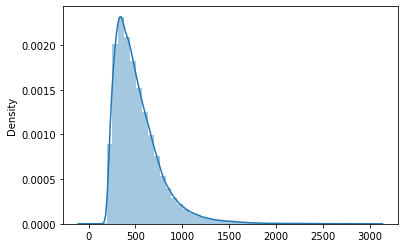

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [27]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_38_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
    
    print('Fold {} end'.format(count))
    count += 1

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.7672882479929

In [30]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [31]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [32]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [33]:
shap_summary_df.index = x_train.columns

In [34]:
shap_summary_df.to_csv(basedir + 'shap_top_38.csv')

In [35]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [36]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.404839,91.441985,92.103020,91.313719,95.469229,92.746558
토지면적over총연면적times공시지가,83.375255,80.288778,80.952629,77.929235,87.903285,82.089836
year_linear,65.077830,62.956299,62.967800,65.026624,65.905352,64.386781
건축년도,52.981249,50.072442,51.946509,50.436145,49.133359,50.913941
전용면적,30.917966,32.360311,34.079053,30.842158,32.823599,32.204617
ynorm,31.421186,31.865905,31.365862,31.940117,32.681493,31.854913
xy,22.583396,22.297677,21.851456,21.629769,20.979456,21.868351
x_2nd,20.642076,20.276112,19.190990,19.520095,19.442866,19.814428
층mean,12.506866,11.118084,11.620605,11.440655,13.280058,11.993253
주건축물수,10.835173,10.332189,10.357152,10.002491,11.657288,10.636859


In [37]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
가축사육제한구역,2.615130,2.329568,2.992413,2.561269,2.719103,2.643497
층min,2.907505,2.529680,2.387542,2.444299,2.599641,2.573733
옥외자주식대수,2.604489,2.373226,2.374660,2.865164,2.500106,2.543529
부속건축물면적,2.211047,2.739801,1.878228,2.341963,2.086440,2.251496
지붕_평지붕_fraction,2.222986,2.162971,2.176358,2.356512,2.131877,2.210141
(한강)폐기물매립시설_설치제한지역,2.130298,2.108246,2.274384,1.996451,2.028048,2.107486
건물나이,2.124021,2.020100,2.219614,2.149782,2.012879,2.105279
month_sin,1.760199,1.955499,2.024674,1.880836,2.092052,1.942652
지형형상,1.465818,1.618907,1.603929,1.541943,1.542137,1.554547
공원,1.431759,1.500681,1.329536,1.440639,1.443281,1.429179


In [39]:
shap_summary_df.shape

(38, 6)

In [40]:
shap_summary_df

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.404839,91.441985,92.103020,91.313719,95.469229,92.746558
토지면적over총연면적times공시지가,83.375255,80.288778,80.952629,77.929235,87.903285,82.089836
year_linear,65.077830,62.956299,62.967800,65.026624,65.905352,64.386781
건축년도,52.981249,50.072442,51.946509,50.436145,49.133359,50.913941
전용면적,30.917966,32.360311,34.079053,30.842158,32.823599,32.204617
ynorm,31.421186,31.865905,31.365862,31.940117,32.681493,31.854913
xy,22.583396,22.297677,21.851456,21.629769,20.979456,21.868351
x_2nd,20.642076,20.276112,19.190990,19.520095,19.442866,19.814428
층mean,12.506866,11.118084,11.620605,11.440655,13.280058,11.993253
주건축물수,10.835173,10.332189,10.357152,10.002491,11.657288,10.636859


In [38]:
#